In [1]:
from utils_v1 import *
experiment_path = 'D:/jorg/phd/fifth_semester/project_forestcare/dataset_deforestation/experiments/'
label_path = 'D:/jorg/phd/fifth_semester/project_forestcare/cloud_removal/dataset/Para_10m/'
optical_im_path = 'D:/jorg/phd/fifth_semester/project_forestcare/cloud_removal/dataset/Para_10m/Sentinel2_2018/'

In [2]:
# Loading reference
label_mask = np.load(label_path + 'mask_label_17730x9203.npy').astype('float32')
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

Mask label shape:  
 (17730, 9203) 
 Unique values:  
 [0. 1. 2.]


In [3]:
# Creating tile mask
grid_x, grid_y = 5,4
mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], grid_size=(grid_x, grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [4]:
selected_class = 1

label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation == selected_class] = 10
label_mask_current_deforestation[label_mask_current_deforestation != 10] = 0
label_mask_current_deforestation[label_mask_current_deforestation == 10] = 1


In [5]:
# Loading image stack
image_stack = np.load(optical_im_path + 'optical_im.npy').astype('float32')
print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

Image shape:  (17730, 9203, 20)
mask:  (17730, 9200)
image stack:  (17730, 9200, 20)
ref : (17730, 9200)


In [6]:
# Defining tiles for training, validation and test sets
tiles_tr = [1,3,5,8,11,13,14,20] 
tiles_val = [6,19]
tiles_ts = list(set(np.arange(grid_x * grid_y)+1)-set(tiles_tr)-set(tiles_val))
    
print('Training tiles: ', tiles_tr)
print('Validation tiles: ', tiles_val)
print('Test tiles: ', tiles_ts)

# Training and validation mask
mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')

for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [7]:
# Extracting patches from the idx matrix
overlap = 0.7
patch_size = 128
batch_size = 32
im_idx = create_idx_image(label_mask)
patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size)
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size)
del im_idx

In [8]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2))
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2))
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training and validation patches:  ', len(patches_idx_trn), len(patches_idx_val))

Number of training and validation patches:   41812 10260


In [9]:
# Keeping patches with 2% of def class
X_train = retrieve_idx_percentage(label_mask, patches_idx_trn, patch_size, pertentage = 0.2)
X_valid = retrieve_idx_percentage(label_mask, patches_idx_val, patch_size, pertentage = 0.2)
print('training samples: ', X_train.shape, 'validation samples: ', X_valid.shape)
del patches_idx_trn, patches_idx_val

training samples:  (3753, 128, 128) validation samples:  (1033, 128, 128)


In [10]:
# Creating train and validation data generator
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

y_train = np.zeros((len(X_train)))
y_valid = np.zeros((len(X_valid)))

len_X_train = len(X_train)
len_X_valid = len(X_valid)

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), y_valid,
                              batch_size=batch_size,
                              shuffle=False)

del X_train, X_valid
number_class = 3
train_gen_batch = batch_generator(train_gen, image_stack, label_mask, patch_size, number_class)
valid_gen_batch = batch_generator(valid_gen, image_stack, label_mask, patch_size, number_class)
#del image_stack

In [11]:
# Creating folder for the experiment
exp = 1
path_exp = experiment_path + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 10
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [12]:
metrics_all = []
training = False
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        metrics_all.append(end_training)
        del model, history

    # Saving training time
    np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

In [13]:
#%% Test loop
metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
del image_stack

h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

new_model = build_resunet(input_shape=(patch_size_rows,patch_size_cols, c), nb_filters = nb_filters, n_classes=3)

metrics_all =[]

for tm in range(0,times):
    print('time: ', tm)
    model = load_model(path_models+ '/' + method +'_'+str(tm)+'.h5', compile=False)
    
    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
    
    start_test = time.time()
    patch_t = []
    
    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            predictions_ = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_t.append(predictions_[:,:,:,1])
            del predictions_
    ts_time =  time.time() - start_test
    patches_pred = np.asarray(patch_t).astype(np.float32)
    # Recinstructing predicted map
    prob_recontructed = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred)
    np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_recontructed) 

    metrics_all.append(ts_time)
    del prob_recontructed, model, patches_pred
metrics_ = np.asarray(metrics_all)
del image1_pad
# Saving test time
np.save(path_exp+'/metrics_ts.npy', metrics_)

-30.0 -16.0
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


0
1
2
3
4
5
6
7
8
9


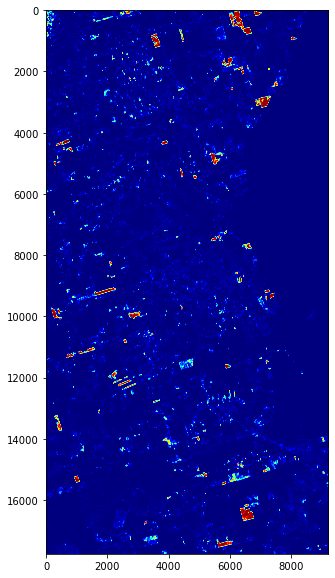

In [14]:
prob_rec = np.zeros((h, w, times))

for tm in range (0, times):
    print(tm)
    prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
np.save(path_maps+'/prob_mean.npy', mean_prob)

fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')

In [15]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1

# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)

0.5
Metrics th = 0.5:  [[73.81111917 86.7992882 ]]


In [16]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [17]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54253101,)
(array([0., 1.], dtype=float32), array([53486282,   766819], dtype=int64))


In [18]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

87.1


In [19]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 10)


In [20]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [21]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [23]:
'''
pred_var = predictive_variance(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_var, ax, title = 'Uncertainty predictive varance')
'''

"\npred_var = predictive_variance(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_var, ax, title = 'Uncertainty predictive varance')\n"

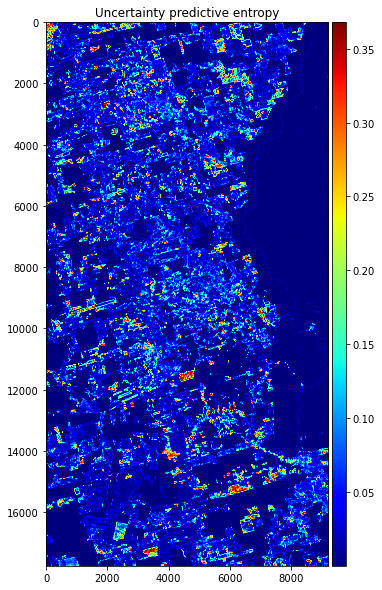

In [24]:
pred_entropy = predictive_entropy(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy, ax, title = 'Uncertainty predictive entropy')

In [25]:

'''
pred_entropy_single = single_experiment_entropy(prob_rec[0])

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\npred_entropy_single = single_experiment_entropy(prob_rec[0])\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [26]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0., 1., 2.], dtype=float32), array([81558000, 65246400, 16311600], dtype=int64))


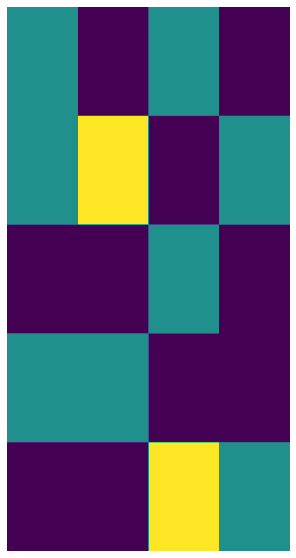

In [27]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('Train val mask.png', dpi=200, bbox_inches='tight')



(array([0., 1.], dtype=float32), array([161273934,   1842066], dtype=int64))


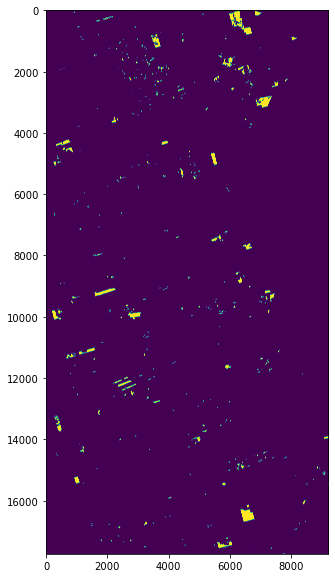

In [28]:
# Computing error mask
# label_mask
print(np.unique(label_mask_current_deforestation, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(label_mask_current_deforestation)


(17730, 9200)
(array([0., 1.]), array([161045139,   2070861], dtype=int64))


ic| predicted_unpad.shape: (17700, 9184)
    predicted.shape: (17730, 9200)


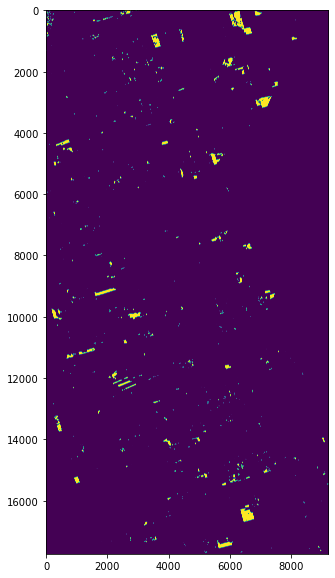

In [29]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
predicted[mean_prob>=0.5] = 1
predicted[mean_prob<0.5] = 0

print(np.unique(predicted, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(predicted)

predicted_unpad = predicted[:-npad[0][1], :-npad[1][1]]
ic(predicted_unpad.shape, predicted.shape)
del predicted

In [30]:

mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [31]:
ic(mask_amazon_ts.shape)
mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


ic| mask_amazon_ts.shape: (17730, 9200)


In [32]:
ic(mask_amazon_ts.shape, predicted_unpad.shape)
label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

ic| mask_amazon_ts.shape: (17700, 9184)
    predicted_unpad.shape: (17700, 9184)


In [33]:
label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [34]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\jorg\\phd\\fifth_semester\\project_forestcare\\deforestation_uncertainty\\utils_v1.py'>

In [35]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob_unpad[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)

mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
        mean_prob_test)*100, 2)

ic(f1, precision, recall, mAP)

ic| predicted_test.shape: (81249792,)
ic| predicted_test.shape: (54010622,)
ic| f1: 79.23, precision: 84.93, recall: 74.24, mAP: 87.17


(79.23, 84.93, 74.24, 87.17)

### Metrics for validation set in forest/deforestation detection

In [36]:
mask_tr_val = mask_tr_val[:-npad[0][1], :-npad[1][1]]

In [37]:


label_mask_val = label_mask[mask_tr_val == 2]
predicted_val = predicted_unpad[mask_tr_val == 2]
mean_prob_val = mean_prob_unpad[mask_tr_val == 2]

predicted_val = predicted_val[label_mask_val != 2]
mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val = label_mask_val[label_mask_val != 2]

ic(np.unique(label_mask_val, return_counts=True),
    np.unique(predicted_val, return_counts=True))



ic| np.unique(label_mask_val, return_counts=True): (array([0., 1.], dtype=float32), array([9158590,  271037], dtype=int64))
    np.unique(predicted_val, return_counts=True): (array([0., 1.]), array([9142153,  287474], dtype=int64))


((array([0., 1.], dtype=float32), array([9158590,  271037], dtype=int64)),
 (array([0., 1.]), array([9142153,  287474], dtype=int64)))

In [38]:

f1_val = round(f1_score(label_mask_val, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 84.0
    precision_val: 81.6
    recall_val: 86.55
    mAP_val: 89.06


(84.0, 81.6, 86.55, 89.06)

(array([0., 1.]), array([161457723,   1099077], dtype=int64))


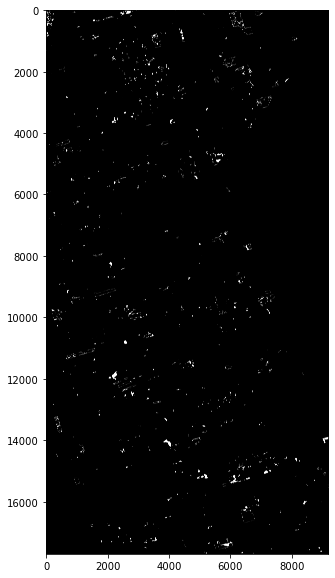

In [39]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)


In [40]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\jorg\\phd\\fifth_semester\\project_forestcare\\deforestation_uncertainty\\utils_v1.py'>

In [41]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 

ic(error_mask.shape, mask_tr_val.shape, 
        utils_v1.getTestVectorFromIm(error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val.shape)
error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17700, 9184)
ic| mask_amazon_ts.shape: (17700, 9184)
ic| label_mask_test.shape: (81249792,)
ic| error_mask.shape: (17700, 9184)
    mask_tr_val.shape: (17700, 9184)
    utils_v1.getTestVectorFromIm(error_mask, mask_tr_val, mask_return_value = 2): array([0., 0., 0., ..., 0., 0., 0.])
    label_mask_val.shape: (9429627,)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 16242600 but corresponding boolean dimension is 9429627